Mom strat

In [3]:
# Descriptive statistics table (reads Market Cap from CSV files and includes Unit Root)
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# -------- config --------
DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
TICKERS = ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK','JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE', 'RHHBY', 'SNY']
SAVE_CSV = "descriptive_stats_with_unitroot_mcap.csv"  # optional output file

# -------- helpers --------
def load_one(ticker):
    """Load one ticker's CSV, compute daily returns (in %) and get latest market cap."""
    path = os.path.join(DATA_DIR, f"{ticker}.csv")
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date")
    
    if "Close" not in df.columns:
        raise ValueError(f"{ticker}.csv missing 'Close' column")
    df["Adj Close"] = df["Close"]
    df["ret"] = df["Adj Close"].pct_change() * 100  # daily return in %
    df["Ticker"] = ticker

    # find market cap column (case-insensitive)
    mcap_col = next((col for col in df.columns if col.lower() in ["marketcap", "mcap", "market_cap"]), None)
    if mcap_col:
        # take the most recent valid value
        latest_mcap = df[mcap_col].dropna().iloc[-1]
    else:
        latest_mcap = np.nan

    return df[["Date","Ticker","ret"]], latest_mcap

# -------- load all tickers --------
rets_list = []
market_caps = {}

for t in TICKERS:
    df, mcap = load_one(t)
    rets_list.append(df)
    market_caps[t] = mcap

rets = pd.concat(rets_list, ignore_index=True)
daily_pct_change = rets.pivot(index="Date", columns="Ticker", values="ret").dropna()

# -------- descriptive stats --------
stats = daily_pct_change.describe().T.rename(
    columns={"count":"Obs","mean":"Mean","std":"σ","min":"Min","max":"Max"}
)[["Obs","Mean","σ","Min","Max"]].round(3)

# -------- ADF Unit Root Test --------
unit_root_results = {}
for ticker in daily_pct_change.columns:
    try:
        adf_stat, pval, *_ = adfuller(daily_pct_change[ticker].dropna(), autolag='AIC')
        stars = "***" if pval < 0.01 else "**" if pval < 0.05 else "*" if pval < 0.1 else ""
        unit_root_results[ticker] = f"{adf_stat:.2f}{stars}"
    except Exception as e:
        unit_root_results[ticker] = np.nan

stats["Unit root"] = stats.index.map(unit_root_results)

# -------- Market Cap --------
stats["Mcap"] = stats.index.map(market_caps)

# -------- reorder & sort --------
stats = stats[["Obs","Mean","σ","Min","Max","Unit root","Mcap"]]
stats = stats.sort_values(by="Mcap", ascending=False)

# -------- display formatted table --------
styled = (
    stats.style
    .format({
        "Mcap": "{:,.0f}",
        "Mean": "{:.2f}",
        "σ": "{:.2f}",
        "Min": "{:.2f}",
        "Max": "{:.2f}"
    })
  
    .set_table_styles([
        {"selector": "caption", "props": [("font-size", "13px"), ("font-weight", "bold"), ("text-align", "center")]}
    ])
)

display(styled)

if SAVE_CSV:
    stats.to_csv(SAVE_CSV, index_label="Ticker")
    print(f" Saved table with unit root and market cap to: {SAVE_CSV}")


,Obs,Mean,σ,Min,Max,Unit root,Mcap
Ticker,,,,,,,
LLY,2515.000000,0.11,1.76,-10.52,15.68,-16.44***,"692,064,617,948"
JNJ,2515.000000,0.02,1.14,-10.04,8.00,-16.32***,"348,293,955,909"
ABBV,2515.000000,0.05,1.69,-16.25,13.77,-12.26***,"313,917,396,167"
NVO,2515.000000,0.07,1.77,-17.83,17.23,-51.94***,"289,763,351,293"
MRK,2515.000000,0.03,1.36,-9.86,10.41,-16.97***,"248,479,482,215"
AZN,2515.000000,0.04,1.55,-14.91,9.29,-16.91***,"203,146,007,969"
RHHBY,2515.000000,0.01,1.35,-9.10,13.01,-17.70***,"192,433,292,928"
NVS,2515.000000,0.01,1.21,-9.82,8.00,-18.31***,"188,377,868,998"
PFE,2515.000000,0.01,1.47,-7.74,10.86,-11.03***,"150,837,658,669"


 Saved table with unit root and market cap to: descriptive_stats_with_unitroot_mcap.csv


Saved: daily_returns_grid_all_years.png


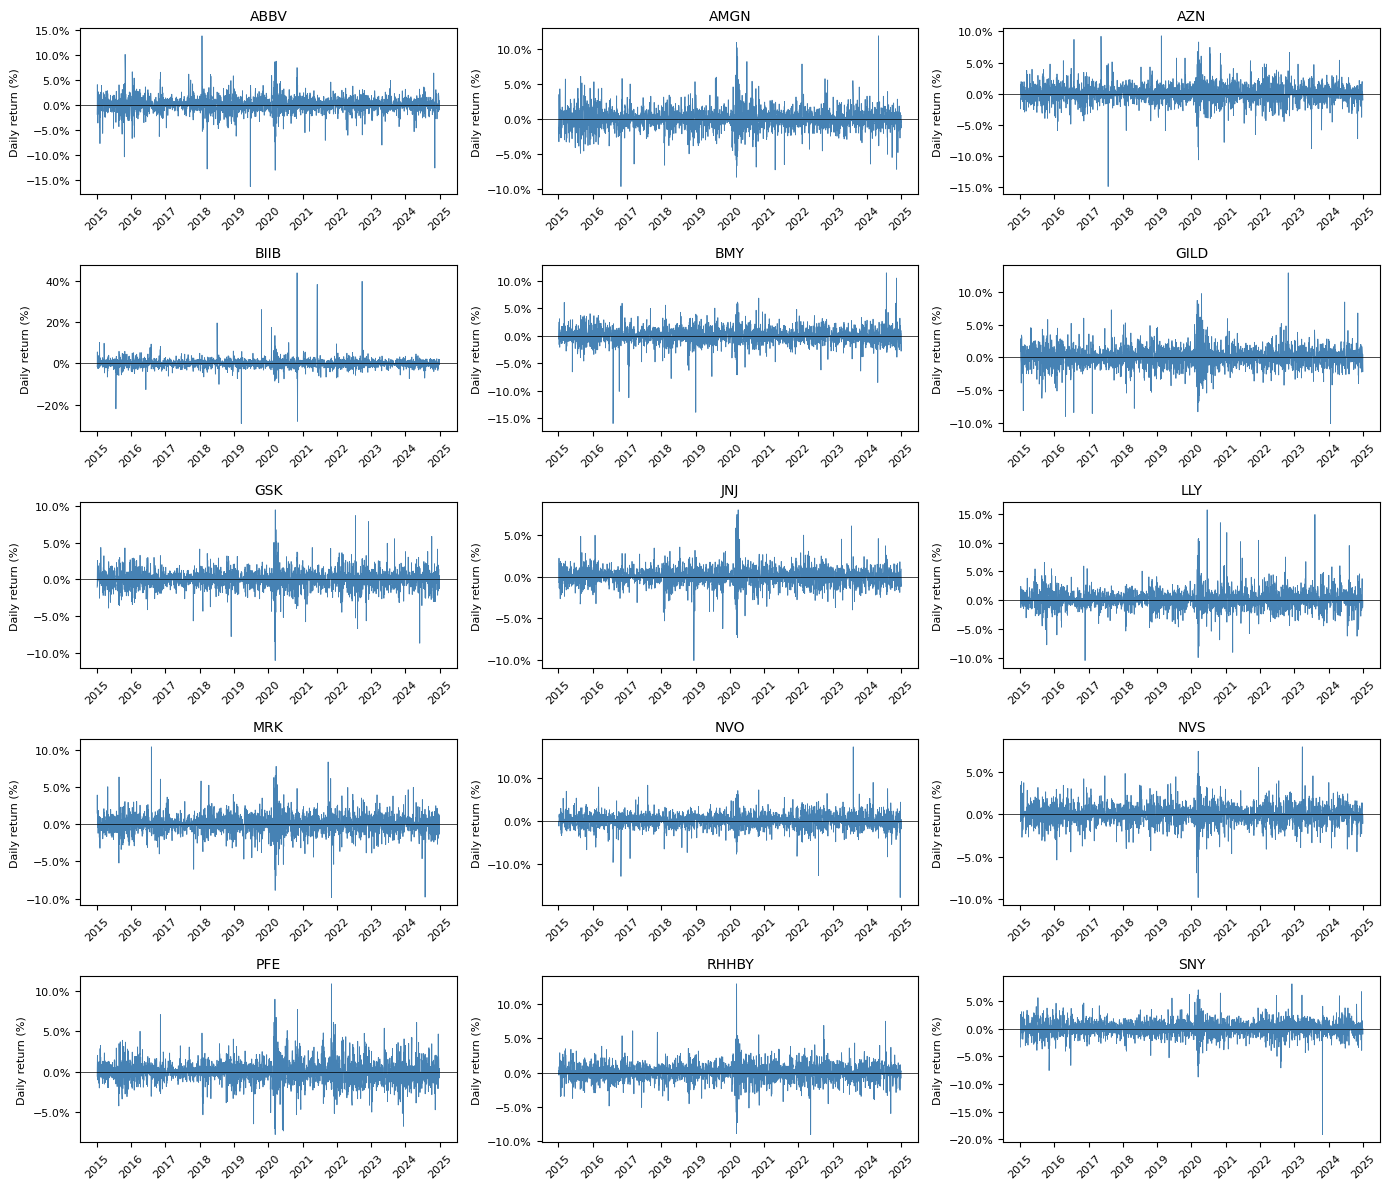

In [4]:
# Daily returns subplots (percent version)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

# -------- config --------
DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
TICKERS = ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK', 'JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE', 'RHHBY', 'SNY']
SAVE_PNG = "daily_returns_grid_all_years.png"

# -------- helpers --------
def list_tickers(path):
    if not os.path.isdir(path):
        raise FileNotFoundError(f"Data directory not found: {path}")
    return sorted(os.path.splitext(f)[0] for f in os.listdir(path) if f.lower().endswith(".csv"))

def load_one(ticker):
    df = pd.read_csv(os.path.join(DATA_DIR, f"{ticker}.csv"), parse_dates=["Date"]).sort_values("Date")
    if "Close" not in df.columns:
        raise ValueError(f"{ticker}.csv missing 'Close' column")
    # if you don't have adjusted prices, mirror Close
    df["Adj Close"] = df["Close"]
    # convert to PERCENT returns
    df["ret_pct"] = df["Adj Close"].pct_change() * 100.0
    df["Ticker"] = ticker
    return df[["Date","Ticker","ret_pct"]]

# -------- compute returns --------
tickers = TICKERS or list_tickers(DATA_DIR)
rets = pd.concat([load_one(t) for t in tickers], ignore_index=True)
daily_ret_pct = rets.pivot(index="Date", columns="Ticker", values="ret_pct").sort_index()

# -------- grid setup --------
n = len(daily_ret_pct.columns)
n_cols = 3
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 2.5), sharex=False)
axes = np.atleast_1d(axes).ravel()

# -------- plot --------
for i, t in enumerate(daily_ret_pct.columns):
    ax = axes[i]
    ax.plot(daily_ret_pct.index, daily_ret_pct[t], linewidth=0.6, color="steelblue")
    ax.axhline(0, color="black", linewidth=0.5)
    ax.set_title(t, fontsize=10)
    ax.set_ylabel("Daily return (%)", fontsize=8)

    # x-axis formatting
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

    # y-axis in percent (values already in -5 to +5 etc.)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.tight_layout(rect=[0, 0, 1, 0.96])

if SAVE_PNG:
    fig.savefig(SAVE_PNG, dpi=200, bbox_inches="tight")
    print(f"Saved: {SAVE_PNG}")

plt.show()


C:/Users/cooki/OneDrive/Skrivebord/by_ticker_csv

Using 15 tickers: ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY']...
3/5  σ=1.9355  Profit=53.52%  Weekly=0.11%
5/5  σ=2.0626  Profit=161.14%  Weekly=0.22%
15/5  σ=2.0266  Profit=71.35%  Weekly=0.13%
30/5  σ=2.0393  Profit=196.23%  Weekly=0.24%


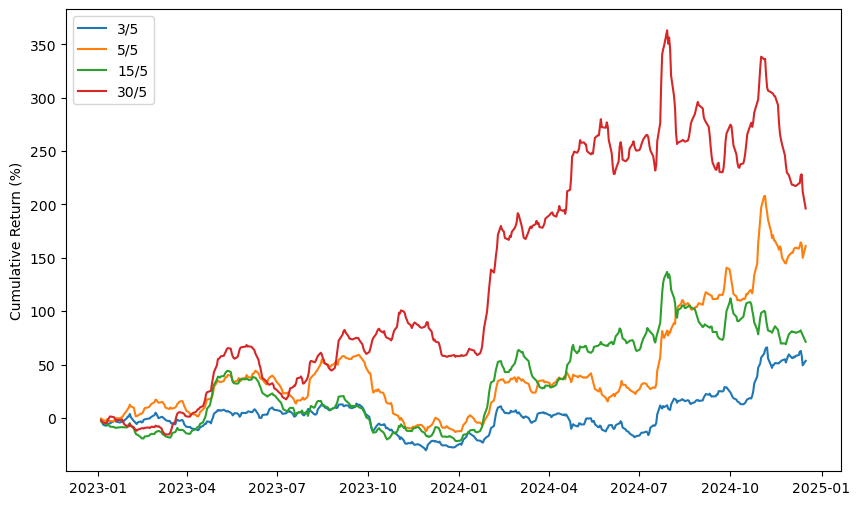

Average 3M T-bill yield over 2023-01-04–2024-12-16: 5.25%


,Obs,Mean (weekly %),Std (weekly %),Sharpe (annual),Ann. Return (%),Ann. Vol (%),RF (annual %)
Strategy,,,,,,,
J=3/5,491,0.106,1.935,0.013,5.437,13.686,5.249
J=5/5,491,0.217,2.063,0.392,11.429,14.585,5.249
J=15/5,491,0.130,2.027,0.097,6.716,14.331,5.249
J=30/5,491,0.242,2.039,0.484,12.844,14.420,5.249


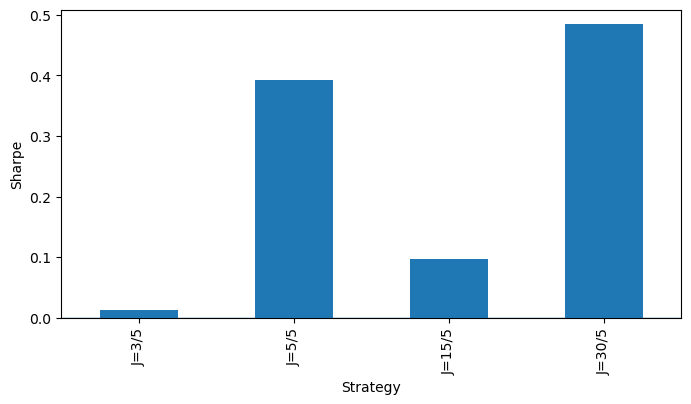

      K=3 Winners (%)  K=3 Losers (%)  K=3 W-L (%)  K=5 Winners (%)  \
J=3            -3.626           4.090       -7.716            5.029   
J=5             7.874           6.562        1.311           10.535   
J=15            8.950           2.869        6.081           11.686   
J=30            9.648          11.857       -2.209            9.867   

      K=5 Losers (%)  K=5 W-L (%)  K=15 Winners (%)  K=15 Losers (%)  \
J=3            5.566       -0.538             5.771            0.156   
J=5           11.132       -0.597             5.901            1.833   
J=15           1.322       10.364            12.129            2.454   
J=30          14.330       -4.463            11.684           11.984   

      K=15 W-L (%)  K=30 Winners (%)  K=30 Losers (%)  K=30 W-L (%)  
J=3          5.615             9.375           -0.407         9.782  
J=5          4.068            11.121            0.480        10.641  
J=15         9.675            14.424            2.363        12.061  
J=3

In [5]:
# Pure Momentum Strategy — business-day aware (index-based holding periods)
# ------------------------------------------------------------------------
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
  
# ----------------------------
# Configuration
# ----------------------------
# Path to your unpacked CSV folder
DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"

# Optional filters
TICKERS = ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK',
           'JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE', 'RHHBY', 'SNY']
START = datetime.datetime(2015, 1, 2)
END   = datetime.datetime(2024, 12, 31)
K = 5  # Holding period in BUSINESS days (weekly rebalance ≈ 5 trading days)

# ----------------------------
# Data loading utilities
# ----------------------------
def list_available_tickers():
    """List CSV tickers in the data folder."""
    if not os.path.isdir(DATA_DIR):
        raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")
    tickers = []
    for fn in os.listdir(DATA_DIR):
        if fn.lower().endswith(".csv"):
            tickers.append(os.path.splitext(fn)[0])
    return sorted(tickers)

def load_ticker_data(ticker, start=None, end=None):
    """Load one ticker’s CSV into a DataFrame."""
    path = os.path.join(DATA_DIR, f"{ticker}.csv")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path, parse_dates=["Date"])
    df = df.sort_values("Date")
    if start:
        df = df[df["Date"] >= pd.Timestamp(start)]
    if end:
        df = df[df["Date"] <= pd.Timestamp(end)]
    df["Adj Close"] = df["Close"]
    df["Ticker"] = ticker
    return df

def get_data(tickers, start=None, end=None):
    """Concatenate data for multiple tickers."""
    dfs = [load_ticker_data(t, start, end) for t in tickers]
    all_data = pd.concat(dfs)
    return all_data

# ----------------------------
# Feature preparation
# ----------------------------
def prep_data(tickers, start=None, end=None, K=5):
    all_data = get_data(tickers, start, end)

    daily_close_px = (
        all_data.pivot(index="Date", columns="Ticker", values="Adj Close")
        .sort_index()
    )
    daily_pct_change = daily_close_px.pct_change()

    dly_vars = all_data[["Date", "Ticker", "Adj Close", "Volume"]].rename(columns={"Adj Close": "Price"})
    dly_vars["t-1"] = 0.0
    dly_vars["target"] = 0.0

    # Market returns (unused but kept for completeness)
    mkt_ret = daily_pct_change.mean(axis=1).shift(1)
    def cumret(ser, win): return (ser + 1).rolling(win).apply(np.prod, raw=True) - 1

    # Per-ticker stats
    for coin in tickers:
        sel = dly_vars["Ticker"] == coin
        prices = dly_vars.loc[sel, "Price"]
        dly_vars.loc[sel, "t-1"] = prices.pct_change().shift(1)
        for J in (3, 5, 15, 30):
            dly_vars.loc[sel, f"J_{J}"] = (1 + dly_vars.loc[sel, "t-1"]).rolling(J).apply(np.prod, raw=True) - 1
            dly_vars.loc[sel, f"J_std_{J}"] = (1 + dly_vars.loc[sel, "t-1"]).rolling(J).std()
        # IMPORTANT: shift(-K) uses BUSINESS days because the index is trading dates per ticker
        dly_vars.loc[sel, "target"] = prices.shift(-K) / prices - 1

    dly_vars = dly_vars.dropna().reset_index(drop=True)
    dly_data = dly_vars.set_index("Date")
    dly_target = dly_vars["target"].values
    return dly_vars, dly_data, daily_pct_change, daily_close_px, dly_target

# ----------------------------
# Train/test split
# ----------------------------
def train_test_split(dly_data, daily_close_px, test_ratio=0.2):
    all_dates = sorted(set(dly_data.index).intersection(set(daily_close_px.index)))
    cutoff = int(len(all_dates) * (1 - test_ratio))
    dates_train = pd.Index(all_dates[:cutoff])
    dates_test  = pd.Index(all_dates[cutoff:])

    X_train_df = dly_data.loc[dates_train]
    X_test_df  = dly_data.loc[dates_test]

    data_train = X_train_df.copy()
    data_test  = X_test_df.copy()

    def split_xy(df):
        X = df.reset_index(drop=False)
        y = X["target"].copy()
        X = X.drop(columns=["target","Price","Ticker","Date"], errors="ignore")
        return X, y

    X_train, y_train = split_xy(X_train_df)
    X_test, y_test = split_xy(X_test_df)

    def _reset_with_date(df):
        out = df.reset_index()
        if "Date" not in out.columns and "index" in out.columns:
            out = out.rename(columns={"index": "Date"})
        return out

    return X_train, y_train, X_test, y_test, _reset_with_date(data_train), _reset_with_date(data_test)

# ----------------------------
# Momentum strategy functions
# ----------------------------
def Momentum(pred_r, date, K, daily_close_px):
    """
    pred_r: pivoted DataFrame (index=trading dates, columns=tickers) with the signal (e.g., J_*)
    date:   current trading date (must be in pred_r.index)
    K:      holding period in BUSINESS days (index steps)
    """
    # Ensure 'date' exists in the signal index
    try:
        cur_idx = pred_r.index.get_loc(date)
    except KeyError:
        return np.nan, np.nan, np.nan

    next_idx = cur_idx + K
    if next_idx >= len(pred_r.index):
        return np.nan, np.nan, np.nan

    next_date = pred_r.index[next_idx]

    # Also ensure both dates are present in the price panel
    if (date not in daily_close_px.index) or (next_date not in daily_close_px.index):
        return np.nan, np.nan, np.nan

    # Cross-section on current date
    ret = pred_r.loc[date].reset_index()
    ret.columns = ["Ticker", "Signal"]
    # 3 quantiles: bottom (0), middle (1), top (2)
    ret["quantile"] = pd.qcut(ret["Signal"].rank(method="first"), 3, labels=False)

    winners = ret[ret["quantile"] == 2]["Ticker"]
    losers  = ret[ret["quantile"] == 0]["Ticker"]

    # Compute forward returns using trading dates
    w = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(winners)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(winners)] - 1
    )
    l = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(losers)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(losers)] - 1
    )

    # momentum = winners minus losers; scale to "per business week" (~5 trading days)
    momentum_profit = w.mean() - l.mean()
    return (momentum_profit / K * 5), (w.mean() / K * 5), (-l.mean() / K * 5)

def MOM_Profit(returns, K, daily_close_px):
    """
    Returns:
      frame:      period returns in PERCENT (%)
      cum_frame:  COMPOUNDED cumulative returns in PERCENT (%)
      profit:     final compounded MomentumProfit in PERCENT (%)
    """
    profits, wins, loss, dates = [], [], [], []
    for date in returns.index[:-K]:  # iterate by trading dates (business-day aware)
        mom, win, los = Momentum(returns, date, K, daily_close_px)
        if np.isnan(mom):
            continue
        profits.append(mom); wins.append(win); loss.append(los); dates.append(date)

    # Period returns in percent
    frame = pd.DataFrame(
        {'MomentumProfit': profits, 'Winners': wins, 'Losers': loss},
        index=dates
    ) * 100.0

    # --- COMPOUND to cumulative percentage ---
    # Convert % -> decimal, compound, back to %
    cum_frame = ((1 + frame / 100.0).cumprod() - 1.0) * 100.0

    # Final compounded total return (%) for MomentumProfit
    profit = float(cum_frame['MomentumProfit'].iloc[-1]) if len(cum_frame) else np.nan
    return frame, cum_frame, profit

def PURE_MOM(K, data_test, daily_close_px):
    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index":"Date"})
    out = {}
    for J in (3, 5, 15, 30):
        R = data_test.pivot(index="Date", columns="Ticker", values=f"J_{J}")
        frame, cum_frame, prof = MOM_Profit(R, K, daily_close_px)
        print(f'{J}/{K}  σ={frame.MomentumProfit.std():.4f}  Profit={prof:.2f}%  '
              f'Weekly={frame.MomentumProfit.mean():.2f}%')
        out[J] = (frame, cum_frame, prof)
    return out

# ----------------------------
# Run strategy
# ----------------------------
all_tickers = list_available_tickers()
tickers = TICKERS or all_tickers
print(f"Using {len(tickers)} tickers: {tickers[:5]}...")

dly_vars, dly_data, daily_pct_change, daily_close_px, dly_target = prep_data(tickers, start=START, end=END, K=K)
X_train, y_train, X_test, y_test, data_train, data_test = train_test_split(dly_data, daily_close_px)

results = PURE_MOM(K, data_test, daily_close_px)

# Plot COMPOUNDED cumulative returns in PERCENT
fig, ax = plt.subplots(figsize=(10, 6))
for J in (3, 5, 15, 30):
    ax.plot(results[J][1]['MomentumProfit'], label=f"{J}/{K}")
ax.legend()
ax.set_ylabel("Cumulative Return (%)")
plt.show()

#R_f calculation for the period:
# --- Compute rf_annual from average 3M T-bill over the backtest window ---
try:
    import pandas_datareader.data as web

    # Infer the exact date window from your result series
    rf_dates = pd.Index([])
    for J in (3, 5, 15, 30):
        rf_dates = rf_dates.union(results[J][0].index)

    # Fallback to START/END if results are empty (shouldn't happen)
    rf_start = (rf_dates.min().to_pydatetime().date() if len(rf_dates) else START.date())
    rf_end   = (rf_dates.max().to_pydatetime().date() if len(rf_dates) else END.date())

    # Fetch daily 3M T-bill yield (%), then average and convert to decimal
    rf_data = web.DataReader(
        "DGS3MO", "fred",
        datetime.datetime.combine(rf_start, datetime.time.min),
        datetime.datetime.combine(rf_end,   datetime.time.min)
    ).dropna()

    rf_annual = float(rf_data["DGS3MO"].mean()) / 100.0  # % -> decimal
    print(f"Average 3M T-bill yield over {rf_start}–{rf_end}: {rf_annual*100:.2f}%")

except Exception as e:
    print(" Could not fetch FRED 3M T-bill; using fallback rf_annual = 4.5%.")
    # print("Reason:", e)  # optionally uncomment for debugging
    rf_annual = 0.045


#Sharpe ratio:
periods_per_year =  50

# Convert annual RF to weekly (effective) rate
rf_weekly = (1 + rf_annual) ** (1 / periods_per_year) - 1

rows = []
for J in (3, 5, 15, 30):
    # Get weekly-equivalent returns series in DECIMAL
    s = results[J][0]['MomentumProfit'].astype(float) / 100.0
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if len(s) < 2 or s.std(ddof=1) == 0:
        sharpe = np.nan
    else:
        sharpe = (s.mean() - rf_weekly) / s.std(ddof=1) * np.sqrt(periods_per_year)

    # (Optional) show weekly mean/std and annualized return/vol
    mean_w = s.mean()
    std_w  = s.std(ddof=1)
    # Annualized (geometric) return and vol for reference
    ann_return = (1 + mean_w) ** periods_per_year - 1
    ann_vol    = std_w * np.sqrt(periods_per_year)

    rows.append({
        "Strategy": f"J={J}/{K}",
        "Obs": len(s),
        "Mean (weekly %)": mean_w * 100,
        "Std (weekly %)": std_w * 100,
        "Sharpe (annual)": sharpe,
        "Ann. Return (%)": ann_return * 100,
        "Ann. Vol (%)": ann_vol * 100,
        "RF (annual %)": rf_annual * 100,
    })

sharpe_table = pd.DataFrame(rows).set_index("Strategy")
display(sharpe_table.round(3))

# (Optional) quick bar chart of Sharpe
ax = sharpe_table["Sharpe (annual)"].plot(kind="bar", figsize=(8,4))
ax.set_ylabel("Sharpe")
ax.axhline(0, linewidth=1)
plt.show()


# ----------------------------------------------------
# Momentum summary table for J x K
# ----------------------------------------------------
def momentum_summary_table(data_test, daily_close_px, J_list=(3, 5, 15, 30), K_list=(3, 5, 15, 30)):
    """
    Builds a table with:
      - rows: J (lookback windows)
      - columns: for each K (holding period): Winners, Losers, W-L
    Values are *average weekly returns in percent*.

    Note: 'Losers' is the *short-leg* return (profit from shorting losers),
    consistent with your existing Momentum() definition.
    """
    # Ensure Date is a column
    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index": "Date"})

    # Pre-build signal matrices R_J for each J to avoid recomputing pivots
    R_dict = {}
    for J in J_list:
        R_dict[J] = data_test.pivot(index="Date", columns="Ticker", values=f"J_{J}")

    rows = []
    index_labels = []

    for J in J_list:
        row = {}
        R = R_dict[J]

        for K in K_list:
            # Use your existing MOM_Profit: frame has columns
            # ['MomentumProfit', 'Winners', 'Losers'] in *percent per week*
            frame, _, _ = MOM_Profit(R, K, daily_close_px)

            # Average weekly returns (already in %)
            mean_winners = frame["Winners"].mean()
            mean_losers = frame["Losers"].mean()
            mean_wml = mean_winners-mean_losers

            # Store in row with descriptive column names
            row[f"K={K} Winners (%)"] = mean_winners*100
            row[f"K={K} Losers (%)"] = mean_losers*100
            row[f"K={K} W-L (%)"] = mean_wml*100

        rows.append(row)
        index_labels.append(f"J={J}")

    summary_df = pd.DataFrame(rows, index=index_labels)
    return summary_df


# ----------------------------------------------------
# Example usage (after you already have data_test, daily_close_px)
# ----------------------------------------------------
mom_table = momentum_summary_table(data_test, daily_close_px,
                                   J_list=(3, 5, 15, 30),
                                   K_list=(3, 5, 15, 30))

print(mom_table.round(3))

# ----------------------------------------------------
# Risk table: volatility & Sharpe for J x K
# ----------------------------------------------------
def momentum_risk_table(
    data_test,
    daily_close_px,
    rf_annual,
    J_list=(3, 5, 15, 30),
    K_list=(3, 5, 15, 30),
    periods_per_year=50,
):
    
    # Convert annual RF to effective weekly rate
    rf_weekly = (1 + rf_annual) ** (1 / periods_per_year) - 1

    # Ensure Date is a column
    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index": "Date"})

    # Pre-build signal matrices R_J for each J
    R_dict = {}
    for J in J_list:
        R_dict[J] = data_test.pivot(index="Date", columns="Ticker", values=f"J_{J}")

    rows = []
    index_labels = []

    for J in J_list:
        row = {}
        R = R_dict[J]

        for K in K_list:
            # Use MOM_Profit to get the weekly-equivalent momentum returns in %
            frame, _, _ = MOM_Profit(R, K, daily_close_px)

            # MomentumProfit is already in weekly % terms by construction
            s = frame["MomentumProfit"].astype(float) / 100.0  # % -> decimal
            s = s.replace([np.inf, -np.inf], np.nan).dropna()

            if len(s) < 2 or s.std(ddof=1) == 0:
                sharpe = np.nan
                std_w = np.nan
                ann_vol = np.nan
            else:
                mean_w = s.mean()
                std_w = s.std(ddof=1)
                sharpe = (mean_w - rf_weekly) / std_w * np.sqrt(periods_per_year)
                ann_vol = std_w * np.sqrt(periods_per_year)

            row[f"K={K} Std weekly (%)"] = std_w * 100 if pd.notna(std_w) else np.nan
            row[f"K={K} Ann Vol (%)"] = ann_vol * 100 if pd.notna(ann_vol) else np.nan
            row[f"K={K} Sharpe (annual)"] = sharpe

        rows.append(row)
        index_labels.append(f"J={J}")

    risk_df = pd.DataFrame(rows, index=index_labels)
    return risk_df


# ----------------------------------------------------
# Example usage (after rf_annual, data_test, daily_close_px exist)
# ----------------------------------------------------
risk_table = momentum_risk_table(
    data_test,
    daily_close_px,
    rf_annual,
    J_list=(3, 5, 15, 30),
    K_list=(3, 5, 15, 30),
    periods_per_year=50,
)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)

print(risk_table.round(3))

Volatility scaled MOM

VolAdj 3/5  σ=1.9296  Profit=-26.93%  Weekly=-0.05%
VolAdj 5/5  σ=1.9677  Profit=86.71%  Weekly=0.15%
VolAdj 15/5  σ=1.9438  Profit=82.46%  Weekly=0.14%
VolAdj 30/5  σ=1.9726  Profit=213.07%  Weekly=0.25%


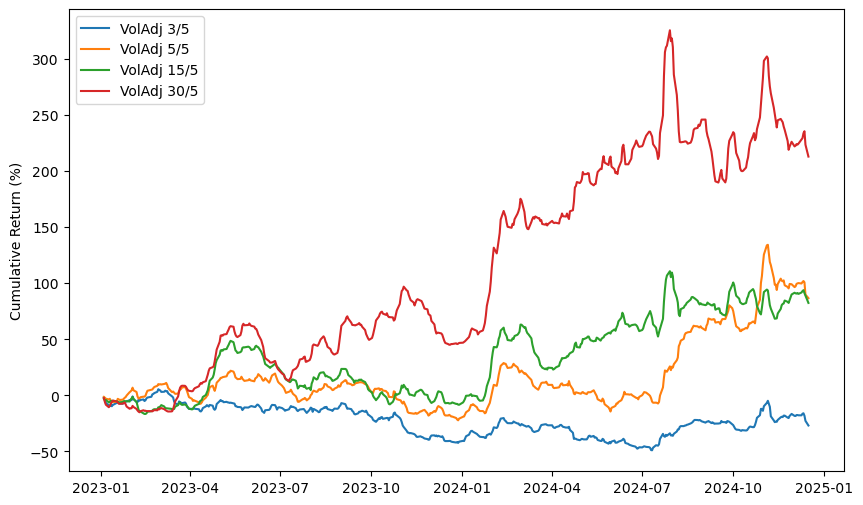

,Obs,Mean (weekly %),Std (weekly %),Sharpe (annual),Ann. Return (%),Ann. Vol (%),RF (annual %)
Strategy,,,,,,,
VolAdj J=3/5,491,-0.045,1.930,-0.541,-2.240,13.645,5.249
VolAdj J=5/5,491,0.146,1.968,0.158,7.590,13.914,5.249
VolAdj J=15/5,491,0.141,1.944,0.141,7.314,13.745,5.249
VolAdj J=30/5,491,0.252,1.973,0.536,13.407,13.948,5.249


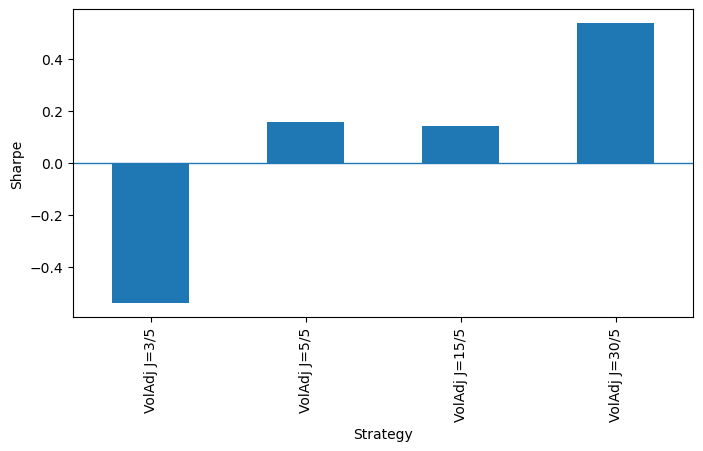

In [6]:

def Momentum_VA(pred_r, date, K, daily_close_px):
    """
    Volatility-adjusted momentum:
    - pred_r: pivoted DataFrame (index=trading dates, columns=tickers)
              with the *volatility-adjusted* signal (e.g. J_J / J_std_J)
    - date:   current trading date
    - K:      holding period in BUSINESS days
    """
    try:
        cur_idx = pred_r.index.get_loc(date)
    except KeyError:
        return np.nan, np.nan, np.nan

    next_idx = cur_idx + K
    if next_idx >= len(pred_r.index):
        return np.nan, np.nan, np.nan

    next_date = pred_r.index[next_idx]

    if (date not in daily_close_px.index) or (next_date not in daily_close_px.index):
        return np.nan, np.nan, np.nan

    # Cross-section on current date, drop NaNs (could arise from zero volatility)
    ret = pred_r.loc[date].dropna().reset_index()
    ret.columns = ["Ticker", "Signal"]
    if len(ret) < 3:
        return np.nan, np.nan, np.nan

    # 3 quantiles: bottom (0), middle (1), top (2)
    ret["quantile"] = pd.qcut(ret["Signal"].rank(method="first"), 3, labels=False)

    winners = ret[ret["quantile"] == 2]["Ticker"]
    losers  = ret[ret["quantile"] == 0]["Ticker"]

    if len(winners) == 0 or len(losers) == 0:
        return np.nan, np.nan, np.nan

    w = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(winners)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(winners)] - 1
    )
    l = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(losers)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(losers)] - 1
    )

    momentum_profit = w.mean() - l.mean()
    return (momentum_profit / K * 5), (w.mean() / K * 5), (-l.mean() / K * 5)

def MOM_Profit_VA(returns, K, daily_close_px):
    """
    Same as MOM_Profit but using Momentum_VA.
    Returns:
      frame:      period returns in PERCENT (%)
      cum_frame:  COMPOUNDED cumulative returns in PERCENT (%)
      profit:     final compounded MomentumProfit in PERCENT (%)
    """
    profits, wins, loss, dates = [], [], [], []
    for date in returns.index[:-K]:
        mom, win, los = Momentum_VA(returns, date, K, daily_close_px)
        if np.isnan(mom):
            continue
        profits.append(mom); wins.append(win); loss.append(los); dates.append(date)

    frame = pd.DataFrame(
        {"MomentumProfit": profits, "Winners": wins, "Losers": loss},
        index=dates
    ) * 100.0

    cum_frame = ((1 + frame / 100.0).cumprod() - 1.0) * 100.0
    profit = float(cum_frame["MomentumProfit"].iloc[-1]) if len(cum_frame) else np.nan
    return frame, cum_frame, profit

def VOLADJ_MOM(K, data_test, daily_close_px):
    """
    Build volatility-adjusted momentum signals:
        Signal_J = J_J / J_std_J
    Then run the same long-winner / short-loser 3-quantile strategy.
    """
    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index": "Date"})

    out = {}
    for J in (3, 5, 15, 30):
        tmp = data_test.copy()

        # Avoid division by zero; if std = 0, set to NaN so that ticker/date is ignored
        denom = tmp[f"J_std_{J}"].replace(0, np.nan)
        tmp[f"VA_{J}"] = tmp[f"J_{J}"] / denom
        tmp[f"VA_{J}"] = tmp[f"VA_{J}"].replace([np.inf, -np.inf], np.nan)

        R = tmp.pivot(index="Date", columns="Ticker", values=f"VA_{J}")

        frame, cum_frame, prof = MOM_Profit_VA(R, K, daily_close_px)
        print(f"VolAdj {J}/{K}  σ={frame.MomentumProfit.std():.4f}  "
              f"Profit={prof:.2f}%  Weekly={frame.MomentumProfit.mean():.2f}%")
        out[J] = (frame, cum_frame, prof)
    return out

# ----------------------------
# Run volatility-adjusted strategy
# ----------------------------
vol_results = VOLADJ_MOM(K, data_test, daily_close_px)

# Plot COMPOUNDED cumulative returns in PERCENT for vol-adjusted strategies
fig, ax = plt.subplots(figsize=(10, 6))
for J in (3, 5, 15, 30):
    ax.plot(vol_results[J][1]['MomentumProfit'], label=f"VolAdj {J}/{K}")
ax.legend()
ax.set_ylabel("Cumulative Return (%)")
plt.show()

# ----------------------------
# Sharpe table for Volatility-Adjusted Momentum
# (reuses rf_annual, periods_per_year, rf_weekly from above)
# ----------------------------

rows_va = []
for J in (3, 5, 15, 30):
    s = vol_results[J][0]['MomentumProfit'].astype(float) / 100.0
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if len(s) < 2 or s.std(ddof=1) == 0:
        sharpe = np.nan
    else:
        sharpe = (s.mean() - rf_weekly) / s.std(ddof=1) * np.sqrt(periods_per_year)

    mean_w = s.mean()
    std_w  = s.std(ddof=1)
    ann_return = (1 + mean_w) ** periods_per_year - 1
    ann_vol    = std_w * np.sqrt(periods_per_year)

    rows_va.append({
        "Strategy": f"VolAdj J={J}/{K}",
        "Obs": len(s),
        "Mean (weekly %)": mean_w * 100,
        "Std (weekly %)": std_w * 100,
        "Sharpe (annual)": sharpe,
        "Ann. Return (%)": ann_return * 100,
        "Ann. Vol (%)": ann_vol * 100,
        "RF (annual %)": rf_annual * 100,
    })

sharpe_table_va = pd.DataFrame(rows_va).set_index("Strategy")
display(sharpe_table_va.round(3))

# Bar chart of Sharpe for vol-adjusted strategies
ax = sharpe_table_va["Sharpe (annual)"].plot(
    kind="bar", figsize=(8, 4),
   
)
ax.set_ylabel("Sharpe")
ax.axhline(0, linewidth=1)
plt.show()


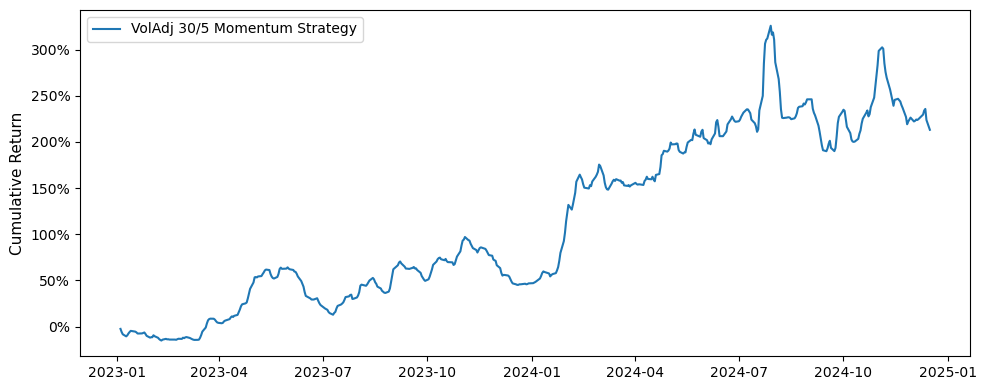

In [7]:
from matplotlib.ticker import PercentFormatter

# --- Figure 19: Volatility-adjusted 30/30 WML cumulative returns ---
J_star = 30     # lookback window (30)
K_star = K      # holding period – should be set to 30 earlier

cum_3030_va = vol_results[J_star][1]["MomentumProfit"]  # compounded cumulative (%) series

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(cum_3030_va.index, cum_3030_va.values, label=f"VolAdj {J_star}/{K_star} Momentum Strategy")

# Formatting
ax.set_ylabel("Cumulative Return", fontsize=11)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(PercentFormatter())  # convert automatically to %
ax.legend(loc="upper left", frameon=True)


plt.tight_layout()
fig.savefig("figure19_voladj_3030.png", dpi=300, bbox_inches="tight")
plt.show()


Random forrest MOM

After date filter: 2023-01-03 00:00:00 → 2024-12-31 00:00:00
Loaded 15 tickers: ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD'] ...
Date span: 2023-01-03 → 2024-12-31 | rows=7,530
Tickers kept after MIN_HISTORY filter (60): 15
Feature matrix: X=(6990, 12), y=(6990,)
Train: (5580, 12), Test: (1410, 12)
RandomForest — R^2 train: 0.068, test: -0.073 | RMSE train: 0.03144, test: 0.03482


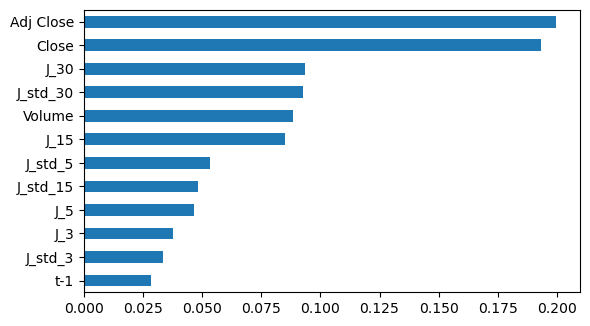

Backtest observations: 461 rebalancing dates


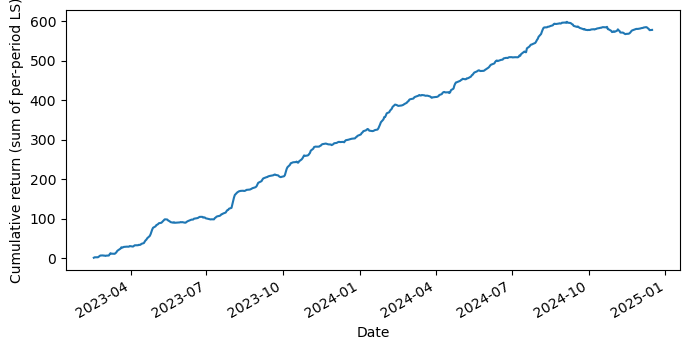

LS mean per rebalance: 1.2545% | std: 2.1259%


In [8]:
import zipfile
import io
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# -----------------------
# Config
# -----------------------
# -----------------------
# Config
# -----------------------
DATA_FOLDER = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
K_HOLD = 5      # stocks → 1 trading week (business days)
TEST_SIZE = 0.20
MIN_HISTORY = 60

# -----------------------
# Helpers: load & tidy
# -----------------------
import os

def load_all_from_folder(folder_path):
    """
    Reads all CSVs in a directory (e.g. by_ticker_csv/<TICKER>.csv)
    and concatenates them into one DataFrame.
    """
    rows = []
    for file in os.listdir(folder_path):
        if not file.lower().endswith(".csv"):
            continue
        path = os.path.join(folder_path, file)
        df = pd.read_csv(path)
        keep = ["Date", "Ticker", "Close", "Volume"]
        missing = [c for c in keep if c not in df.columns]
        if missing:
            raise ValueError(f"{file} missing required columns: {missing}")
        df = df[keep].copy()
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date").reset_index(drop=True)
        df["Adj Close"] = df["Close"]
        rows.append(df)
    full = pd.concat(rows, ignore_index=True)
    full = full.drop_duplicates(subset=["Ticker", "Date"]).sort_values(["Ticker", "Date"])
    return full

full = load_all_from_folder(DATA_FOLDER)

# -----------------------
# Restrict sample period
# -----------------------
START = pd.Timestamp("2023-01-01")
END   = pd.Timestamp("2025-01-01")

full = full[(full["Date"] >= START) & (full["Date"] <= END)].copy()

print("After date filter:", full["Date"].min(), "→", full["Date"].max())

tickers = sorted(full["Ticker"].unique().tolist())
print(f"Loaded {len(tickers)} tickers:", tickers[:6], "..." if len(tickers) > 6 else "")
print(f"Date span: {full['Date'].min().date()} → {full['Date'].max().date()} | rows={len(full):,}")

# Require some basic history
ok_counts = full.groupby("Ticker")["Date"].count()
keep = ok_counts[ok_counts >= MIN_HISTORY].index.tolist()
full = full[full["Ticker"].isin(keep)].copy()
tickers = keep
print(f"Tickers kept after MIN_HISTORY filter ({MIN_HISTORY}): {len(tickers)}")

# -----------------------
# Feature engineering (replicates All.py logic)
# -----------------------
def make_features(panel_df, tickers, K):
    """
    Build per-asset features and market features, then drop market features
    to match the thesis' final modeling step (as in All.py).
    """
    # Pivot close for market return calculations
    px = panel_df.pivot(index="Date", columns="Ticker", values="Adj Close").sort_index()
    ret = px.pct_change()

    # Market series (cross-sectional mean)
    mkt_ret = ret.mean(axis=1)

    # Cumulative market returns (shifted by 1 to avoid look-ahead)
    mkt_cum_3  = (mkt_ret + 1).shift(1).rolling(3).apply(np.prod, raw=True)  - 1
    mkt_cum_5  = (mkt_ret + 1).shift(1).rolling(5).apply(np.prod, raw=True)  - 1
    mkt_cum_15 = (mkt_ret + 1).shift(1).rolling(15).apply(np.prod, raw=True) - 1
    mkt_cum_30 = (mkt_ret + 1).shift(1).rolling(30).apply(np.prod, raw=True) - 1

    # Market std windows
    mkt_std_3  = (mkt_ret + 1).shift(1).rolling(3).std()
    mkt_std_5  = (mkt_ret + 1).shift(1).rolling(5).std()
    mkt_std_15 = (mkt_ret + 1).shift(1).rolling(15).std()
    mkt_std_30 = (mkt_ret + 1).shift(1).rolling(30).std()

    # Build per-row frame like All.py started with
    d = panel_df.sort_values(["Ticker", "Date"]).copy()
    d["Price"]  = d["Adj Close"]
    d["t-1"]    = np.nan
    d["J_3"]    = np.nan
    d["J_5"]    = np.nan
    d["J_15"]   = np.nan
    d["J_30"]   = np.nan
    d["J_std_3"]  = np.nan
    d["J_std_5"]  = np.nan
    d["J_std_15"] = np.nan
    d["J_std_30"] = np.nan
    # Market features to be dropped later (kept here to mirror pipeline)
    d["mkt_t-1"]      = np.nan
    d["mkt_J_ret_3"]  = np.nan
    d["mkt_J_ret_5"]  = np.nan
    d["mkt_J_ret_15"] = np.nan
    d["mkt_J_ret_30"] = np.nan
    d["mkt_J_std_3"]  = np.nan
    d["mkt_J_std_5"]  = np.nan
    d["mkt_J_std_15"] = np.nan
    d["mkt_J_std_30"] = np.nan

    # Per-ticker features (like All.py)
    for t in tickers:
        mask = d["Ticker"].eq(t)
        dd   = d.loc[mask, ["Date", "Price", "Volume"]].copy()

        r = dd["Price"].pct_change()

        J_3  = (r + 1).shift(2).rolling(2).apply(np.prod, raw=True)  - 1  # (3-1) lookback after shift
        J_5  = (r + 1).shift(1).rolling(6).apply(np.prod, raw=True)  - 1
        J_15 = (r + 1).shift(1).rolling(14).apply(np.prod, raw=True) - 1
        J_30 = (r + 1).shift(1).rolling(29).apply(np.prod, raw=True) - 1

        J_std_3  = (r + 1).shift(1).rolling(2).std()
        J_std_5  = (r + 1).shift(1).rolling(6).std()
        J_std_15 = (r + 1).shift(1).rolling(14).std()
        J_std_30 = (r + 1).rolling(29).std()

        # Assign (note All.py shifts t-1 by one more day)
        d.loc[mask, "t-1"]      = r.shift(1).values
        d.loc[mask, "J_3"]      = J_3.values
        d.loc[mask, "J_5"]      = J_5.values
        d.loc[mask, "J_15"]     = J_15.values
        d.loc[mask, "J_30"]     = J_30.values
        d.loc[mask, "J_std_3"]  = J_std_3.values
        d.loc[mask, "J_std_5"]  = J_std_5.values
        d.loc[mask, "J_std_15"] = J_std_15.values
        d.loc[mask, "J_std_30"] = J_std_30.values

        # Market features mapped by date (will drop later to mirror their final step)
        d.loc[mask, "mkt_t-1"]      = mkt_ret.shift(1).reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_ret_3"]  = mkt_cum_3.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_ret_5"]  = mkt_cum_5.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_ret_15"] = mkt_cum_15.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_ret_30"] = mkt_cum_30.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_std_3"]  = mkt_std_3.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_std_5"]  = mkt_std_5.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_std_15"] = mkt_std_15.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_std_30"] = mkt_std_30.reindex(dd["Date"]).values

    # Build K-step ahead *business-day* target per ticker
    d["target"] = np.nan
    for t in tickers:
        mask = d["Ticker"].eq(t)
        dd = d.loc[mask, ["Date", "Price"]].reset_index()
        # future index by position, not calendar date
        price = dd["Price"].values
        # compute shift in *rows* (business days for this ticker)
        future = pd.Series(price).shift(-K) / pd.Series(price) - 1.0
        d.loc[mask, "target"] = future.values

    # Drop rows with missing values
    d = d.dropna().reset_index(drop=True)

    # Also produce pivoted price and return tables for backtest / utility
    daily_close_px = px.loc[d["Date"].min(): d["Date"].max()].copy()
    daily_ret = daily_close_px.pct_change()

    # Create final dly_data (with Ticker/Date retained for later joins)
    dly_data = d.copy()

    # Modeling matrix (drop Ticker/Date later when splitting)
    # Drop the market features to match All.py's final “MARKET FEATURES” removal
    drop_mkt = [
        'mkt_t-1','mkt_J_ret_3','mkt_J_ret_5','mkt_J_ret_15','mkt_J_ret_30',
        'mkt_J_std_3','mkt_J_std_5','mkt_J_std_15','mkt_J_std_30'
    ]
    dly_vars = d.drop(columns=drop_mkt + ["Ticker","Date"]).copy()

    y = dly_vars["target"].values
    X = dly_vars.drop(columns=["target", "Price"]).copy()  # like All.py drops 'Price'

    return X, y, dly_data, daily_close_px, daily_ret

X_all, y_all, dly_data, daily_close_px, daily_ret = make_features(full, tickers, K=K_HOLD)
print(f"Feature matrix: X={X_all.shape}, y={y_all.shape}")

# -----------------------
# Chronological train/test split (as in All.py)
# -----------------------
# We'll split by Date order rather than random shuffle
dates = dly_data["Date"].sort_values().unique()
cut = int((1 - TEST_SIZE) * len(dates))
train_dates, test_dates = dates[:cut], dates[cut:]

train_mask = dly_data["Date"].isin(train_dates)
test_mask  = dly_data["Date"].isin(test_dates)

# We must rebuild X/y with the same row order as dly_data to apply masks properly:
X_full_model = dly_data.drop(columns=[
    'Ticker','Date',
    'mkt_t-1','mkt_J_ret_3','mkt_J_ret_5','mkt_J_ret_15','mkt_J_ret_30',
    'mkt_J_std_3','mkt_J_std_5','mkt_J_std_15','mkt_J_std_30'
]).copy()
# Drop Price (same as All.py)
X_full_model = X_full_model.drop(columns=["Price"])
y_full = X_full_model["target"].values
X_full_model = X_full_model.drop(columns=["target"])

X_train = X_full_model.loc[train_mask.values].reset_index(drop=True)
y_train = y_full[train_mask.values]
X_test  = X_full_model.loc[test_mask.values].reset_index(drop=True)
y_test  = y_full[test_mask.values]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# -----------------------
# Train Random Forest (hyperparams in spirit of All.py)
# -----------------------
rf = RandomForestRegressor(
    n_estimators=450,
    max_features=3,
    max_depth=4,
    min_samples_split=3,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=0
)
rf.fit(X_train, y_train)

pred_train = rf.predict(X_train)
pred_test  = rf.predict(X_test)

r2_tr = r2_score(y_train, pred_train)
r2_te = r2_score(y_test, pred_test)
rmse_tr = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_te = np.sqrt(mean_squared_error(y_test, pred_test))


print(f"RandomForest — R^2 train: {r2_tr:.3f}, test: {r2_te:.3f} | RMSE train: {rmse_tr:.5f}, test: {rmse_te:.5f}")

# -----------------------
# Feature importance plot
# -----------------------
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(6, max(3, len(imp)*0.28)))
imp.plot(kind="barh")
plt.tight_layout()
plt.show()

# -----------------------
# Momentum portfolio backtest driven by model predictions
# (Top vs bottom tercile, equal-weight, K business-day forward PnL)
# -----------------------
def long_short_backtest(dly_data, preds, daily_px, k_steps=K_HOLD):
    """
    At each date:
      - rank predictions cross-sectionally
      - long top tercile tickers, short bottom tercile
      - hold for k_steps business days (using trading index)
    Returns daily series of realized long-short returns for rebalanced dates.
    """
    df = dly_data[["Date","Ticker"]].copy().reset_index(drop=True)
    df["pred"] = preds

    # Make a pivot: rows=Date, cols=Ticker, vals=pred
    pred_pvt = df.pivot(index="Date", columns="Ticker", values="pred").sort_index()

    # We’ll compute realized K-step ahead returns from the price pivot
    px = daily_px.reindex(pred_pvt.index.union(daily_px.index)).sort_index()
    px = px.ffill()  # align any slight mismatch
    idx = px.index

    ls_returns = []
    ls_dates   = []

    for i, dt in enumerate(pred_pvt.index):
        if dt not in idx:
            continue
        # future index position
        pos = idx.get_indexer([dt])[0]
        fpos = pos + k_steps
        if fpos >= len(idx):
            break
        future_dt = idx[fpos]

        row = pred_pvt.loc[dt]
        # drop tickers with missing prices on either end
        valid = row.index[(~px.loc[dt, row.index].isna()) & (~px.loc[future_dt, row.index].isna())]

        if len(valid) < 6:
            continue  # need at least both terciles to form a portfolio

        row = row.loc[valid]
        ranks = row.rank(method="first")
        terc = pd.qcut(ranks, 3, labels=False)

        winners = row.index[terc == 2]
        losers  = row.index[terc == 0]

        if len(winners) == 0 or len(losers) == 0:
            continue

        wret = (px.loc[future_dt, winners] / px.loc[dt, winners] - 1).mean()
        lret = (px.loc[future_dt, losers] / px.loc[dt, losers] - 1).mean()

        ls_returns.append(wret - lret)
        ls_dates.append(dt)

    ls = pd.Series(ls_returns, index=pd.to_datetime(ls_dates)).sort_index()
    return ls

# Build predictions aligned with dly_data rows
pred_full = np.empty(len(dly_data))
pred_full[:] = np.nan
pred_full[train_mask.values] = pred_train
pred_full[test_mask.values]  = pred_test

ls = long_short_backtest(dly_data, pred_full, daily_close_px, k_steps=K_HOLD)
print(f"Backtest observations: {ls.shape[0]} rebalancing dates")

cum = (ls.fillna(0)).cumsum()*100
plt.figure(figsize=(7,3.6))
cum.plot()
plt.ylabel("Cumulative return (sum of per-period LS)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

print(f"LS mean per rebalance: {ls.mean():.4%} | std: {ls.std():.4%}")


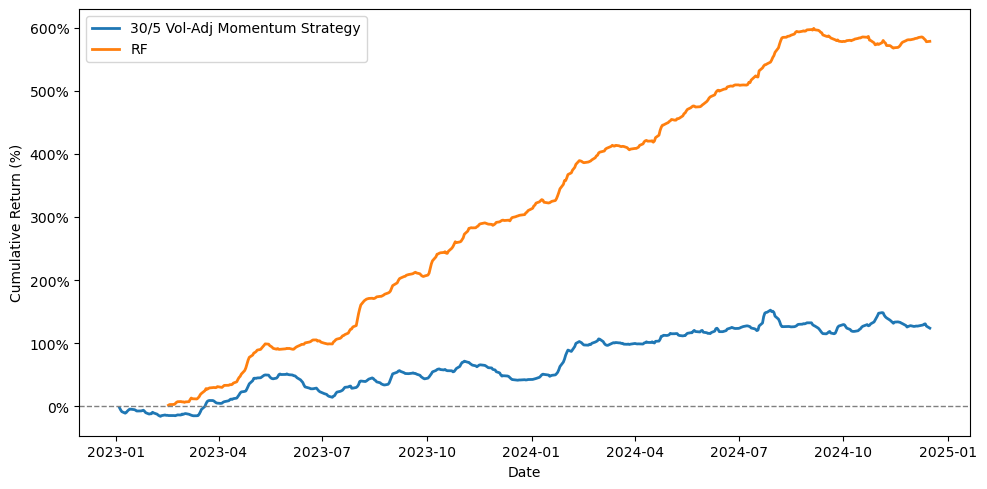


Summary Table (Weekly return, volatility, Sharpe, Max Drawdown):



,r (weekly %),σ (weekly %),Sharpe ratio,Max drawdown (%)
Random Forest,1.25,2.13,3.83,-27.54
30/5 Vol-Adj Momentum,0.25,1.97,0.54,-80.00


In [11]:
start_date= datetime.datetime(2023, 1, 1)

# 1) Per-period returns (already exist):
#    - ls              : RF long–short per-rebalance return (decimal)
#    - vol_results[30] : volatility-adjusted J=30, K=5 momentum results

# 1) Per-period returns (decimal, weekly-ish)
rf_ret = ls[ls.index >= start_date].dropna()               # decimal
va_30_5 = vol_results[30][0]["MomentumProfit"] / 100.0     # % → decimal
va_ret  = va_30_5[va_30_5.index >= start_date].dropna()

# 2) Convert to weekly % and take cumulative SUM (not compound)
rf_pct = rf_ret * 100.0          # decimal → percentage points
va_pct = va_ret * 100.0

rf_cum = rf_pct.cumsum()         # cumulative % points
va_cum = va_pct.cumsum()

# 3) Plot like Figure 21
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(va_cum.index, va_cum / 100.0,
        label="30/5 Vol-Adj Momentum Strategy", linewidth=2)
ax.plot(rf_cum.index, rf_cum / 100.0,
        label="RF", linewidth=2)

ax.axhline(0, linestyle="--", linewidth=1, color="grey")

ax.set_ylabel("Cumulative Return (%)")
ax.set_xlabel("Date")
ax.legend()

# format y-axis as % just like All.py
vals = ax.get_yticks()
ax.set_yticklabels([f"{v:.0%}" for v in vals])

plt.tight_layout()
plt.show()


# ----------------------------------------------------
# Summary Table: Weekly return, volatility, Sharpe, Max Drawdown
#   (RF vs VOL-ADJ 30/5)
# ----------------------------------------------------

def max_drawdown(series):
    """Compute max drawdown in PERCENT for a cumulative % return series."""
    x = (series / 100.0)  # % -> decimal
    peak = x.cummax()
    dd = (x - peak) / peak
    return dd.min() * 100  # back to %

# true risk-free weekly rate (rf_annual already defined earlier)
rf_weekly_rf = (1 + rf_annual) ** (1 / 50) - 1

def summarize(name, s):
    s = s.dropna()

    mean_w = s.mean() * 100      # weekly return in %
    std_w  = s.std() * 100       # weekly vol in %

    if s.std() == 0:
        sharpe = np.nan
    else:
        sharpe = (s.mean() - rf_weekly_rf) / s.std() * np.sqrt(50)

    cum_pct = ((1 + s).cumprod() - 1.0) * 100
    mdd = max_drawdown(cum_pct)

    return {
        "r (weekly %)": mean_w,
        "σ (weekly %)": std_w,
        "Sharpe ratio": sharpe,
        "Max drawdown (%)": mdd,
    }

# Use out-of-sample weekly returns for both strategies
rf_weekly = rf_ret
va_weekly = va_ret

summary = pd.DataFrame({
    "Random Forest": summarize("RF", rf_weekly),
    "30/5 Vol-Adj Momentum": summarize("30/5 VA", va_weekly),
}).T

print("\nSummary Table (Weekly return, volatility, Sharpe, Max Drawdown):\n")
display(summary.round(2))
